In [1]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

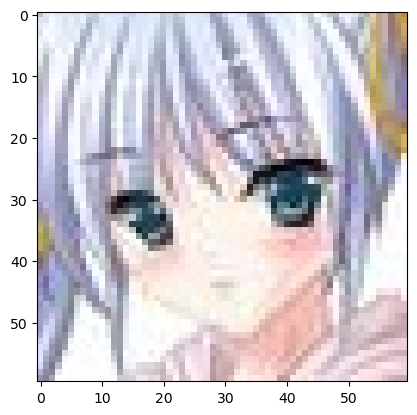

In [2]:
import cv2
example=cv2.imread('/kaggle/input/animefacedataset/images/10005_2004.jpg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(example)

In [4]:
example.shape

(60, 60, 3)

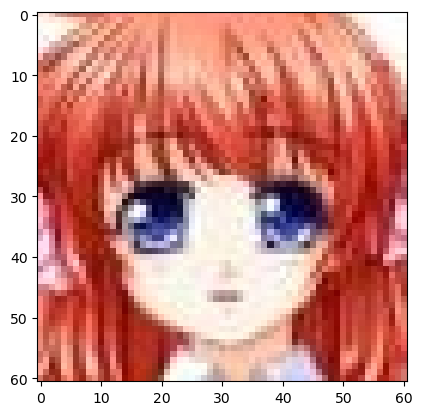

In [13]:
example=cv2.imread('/kaggle/input/animefacedataset/images/10034_2004.jpg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(example)

In [15]:
example.shape

(60, 60, 3)

In [4]:
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3

# Size vector to generate images from
SEED_SIZE = 100

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

Trained = 370
DATA_PATH = '/kaggle/input/animefacedataset'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data = image_dataset_from_directory(
    DATA_PATH,
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed=3,
    shuffle=True,
    interpolation='bilinear',
)
#default batch size 32
def preprocessing(img):
    img = (cast(img,'float32')-127.5)/127.5
    return img
from tensorflow import cast
train_dataset = train_data.map(lambda x: preprocessing(x))

Found 63565 files belonging to 1 classes.


In [22]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s) #just used to convert seconds to HMS formatting

In [23]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))
    
    #Each block doubles the size of image 
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

In [24]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_20 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 8, 8, 256)        

In [25]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model
image_shape = (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS)
discriminator = build_discriminator(image_shape)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)

In [28]:
def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (IMAGE_SIZE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (IMAGE_SIZE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
      255, dtype=np.uint8)
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        c = col * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        image_array[r:r+IMAGE_SIZE,c:c+IMAGE_SIZE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = '/kaggle/working/'

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [29]:
@tf.function
def train_step(images):
  BATCH_SIZE = tf.shape(images)[0]
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
    pred = tf.concat([real_output,fake_output],axis = 0)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(labels,pred)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [30]:
def train(dataset, epochs):
  fixed_seed = tf.random.normal([PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE])
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    if (epoch + 1) % 10 == 0:
        save_images(epoch + Trained,fixed_seed)
  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [17]:
#taking 70% samples for training
total_samples = len(train_dataset)
subset_size = int(total_samples * 0.7) 
train_data_subset = train_dataset.take(subset_size)


In [ ]:
train(train_data_subset, 50)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


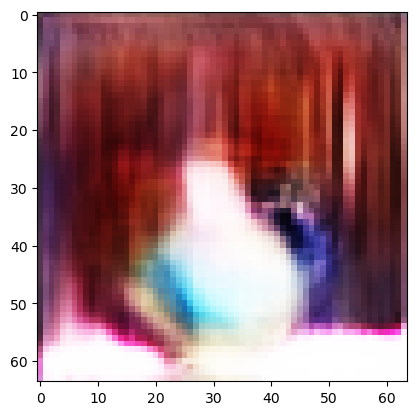

In [59]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)*0.5  + 0.5
decision = discriminator(generated_image)
print (decision)
plt.imshow(generated_image[0,:,:,:])

In [56]:
#This will clear the output directory in kaggle
#taken from kaggle
def remove_folder_contents(folder):
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

remove_folder_contents('/kaggle/working')